# Welcome to CS 5242 **Homework 7**

ASSIGNMENT DEADLINE ⏰ : **6 Nov 2022, 23:59** 

In this assignment, we have three questions. This is the first question and please write the answer in this notebook.

Colab is a hosted Jupyter notebook service that requires no setup to use, while providing access free of charge to computing resources including GPUs. In this semester, we will use Colab to run our experiments.

### **Grades Policy**

We have 10 points for this homework. 15% off per day late, 0 scores if you submit it 7 days after the deadline.

### **Cautions**

**DO NOT** copy the code from the internet, e.g. GitHub.

**DO NOT** use external libraries like Tensorflow, keras in your implementation.

---

### **Contact**

Please feel free to contact us if you have any question about this homework or need any further information.

Slack (Recommend): Lin Qiuxia

TA Email: qiuxia.lin@u.nus.edu

> If you have not join the slack group, you can click [here](https://join.slack.com/t/cs5242ay20222-oiw1784/shared_invite/zt-1eiv24k1t-0J9EI7vz3uQmAHa68qU0aw)

# Question 1 (4 Points)

One of the major drawbacks of R-CNN is that it takes considerable time to generate predictions, as generating region proposals for each image, resizing the crops of regions, and extracting features corresponding to each crop (region proposal), constitute the bottleneck.

Fast R-CNN gets around this problem by passing the entire image through the pretrained model to extract features and then fetching the region of features that correspond to the region proposals (which are obtained from selectivesearch) of the original image. In this question, we will build Fast R-CNN model to solve our truck & bus detection problem. 

Most codes are provided and a few codes are missing. Please enter your codes in the highlighted parts and run all the cells to provide proper outputs. 

Feel free to adjust model hyperparameter values when training the model. 

In [1]:
!pip install -q --upgrade selectivesearch torch_snippets
from torch_snippets import *
import selectivesearch
from google.colab import files
files.upload() # you need to login your kaggle account and upload kaggle.json file which you can get 
# by clicking on Create New API token in your personal account
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d sixhky/open-images-bus-trucks/
!unzip -qq open-images-bus-trucks.zip
from torchvision import transforms, models, datasets
from torch_snippets import Report
from torchvision.ops import nms
import numpy as np
device = 'cuda' if torch.cuda.is_available() else 'cpu'

     |████████████████████████████████| 53 kB 2.3 MB/s 
     |████████████████████████████████| 78 kB 7.5 MB/s 
     |████████████████████████████████| 58 kB 5.9 MB/s 
     |████████████████████████████████| 237 kB 65.5 MB/s 
     |████████████████████████████████| 1.6 MB 47.4 MB/s 
     |████████████████████████████████| 175 kB 54.0 MB/s 
     |████████████████████████████████| 2.2 MB 52.0 MB/s 
     |████████████████████████████████| 51 kB 2.9 MB/s 


Saving kaggle.json to kaggle.json
kaggle.json
100% 366M/367M [00:25<00:00, 16.5MB/s]
100% 367M/367M [00:25<00:00, 15.2MB/s]


In [2]:
IMAGE_ROOT = 'images/images'
DF_RAW = pd.read_csv('df.csv')
print(DF_RAW.head())

ImageID  Source LabelName  Confidence      XMin      XMax  \
0  0000599864fd15b3  xclick       Bus           1  0.343750  0.908750   
1  00006bdb1eb5cd74  xclick     Truck           1  0.276667  0.697500   
2  00006bdb1eb5cd74  xclick     Truck           1  0.702500  0.999167   
3  00010bf498b64bab  xclick       Bus           1  0.156250  0.371250   
4  00013f14dd4e168f  xclick       Bus           1  0.287500  0.999375   

       YMin      YMax  IsOccluded  IsTruncated  ...  IsDepiction  IsInside  \
0  0.156162  0.650047           1            0  ...            0         0   
1  0.141604  0.437343           1            0  ...            0         0   
2  0.204261  0.409774           1            1  ...            0         0   
3  0.269188  0.705228           0            0  ...            0         0   
4  0.194184  0.999062           0            1  ...            0         0   

   XClick1X  XClick2X  XClick3X  XClick4X  XClick1Y  XClick2Y  XClick3Y  \
0  0.421875  0.343750  0.795000  0.908750  0.156162  0.512700  0.650047   
1  0.299167  0.276667  0.697500  0.659167  0.141604  0.241855  0.352130   
2  0.849167  0.702500  0.906667  0.999167  0.204261  0.398496  0.409774   
3  0.274375  0.371250  0.311875  0.156250  0.269188  0.493882  0.705228   
4  0.920000  0.999375  0.648750  0.287500  0.194184  0.303940  0.999062   

   XClick4Y  
0  0.457197  
1  0.437343  
2  0.295739  
3  0.521691  
4  0.523452  

[5 rows x 21 columns]

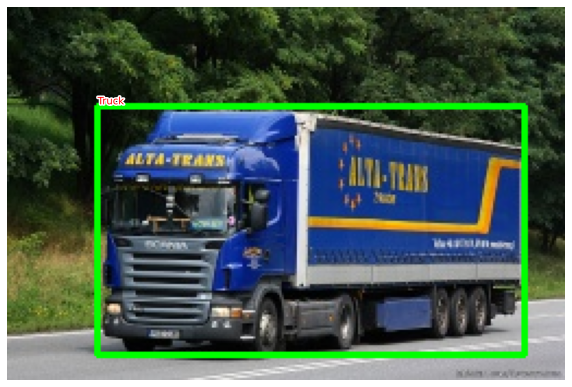

In [3]:
class OpenImages(Dataset):
    def __init__(self, df, image_folder=IMAGE_ROOT):
        self.root = image_folder
        self.df = df
        self.unique_images = df['ImageID'].unique()
    def __len__(self): return len(self.unique_images)
    def __getitem__(self, ix):
        image_id = self.unique_images[ix]
        image_path = f'{self.root}/{image_id}.jpg'
        image = cv2.imread(image_path, 1)[...,::-1] # conver BGR to RGB
        h, w, _ = image.shape
        df = self.df.copy()
        df = df[df['ImageID'] == image_id]
        boxes = df['XMin,YMin,XMax,YMax'.split(',')].values
        boxes = (boxes * np.array([w,h,w,h])).astype(np.uint16).tolist()
        classes = df['LabelName'].values.tolist()
        return image, boxes, classes, image_path
ds = OpenImages(df=DF_RAW)
im, bbs, clss, _ = ds[9]
show(im, bbs=bbs, texts=clss, sz=10)

In [4]:
def extract_candidates(img):
    img_lbl, regions = selectivesearch.selective_search(img, scale=200, min_size=100)
    img_area = np.prod(img.shape[:2])
    candidates = []
    for r in regions:
        if r['rect'] in candidates: continue
        if r['size'] < (0.05*img_area): continue
        if r['size'] > (1*img_area): continue
        x, y, w, h = r['rect']
        candidates.append(list(r['rect']))
    return candidates
def extract_iou(boxA, boxB, epsilon=1e-5):
    x1 = max(boxA[0], boxB[0])
    y1 = max(boxA[1], boxB[1])
    x2 = min(boxA[2], boxB[2])
    y2 = min(boxA[3], boxB[3])
    width = (x2 - x1)
    height = (y2 - y1)
    if (width<0) or (height <0):
        return 0.0
    area_overlap = width * height
    area_a = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    area_b = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    area_combined = area_a + area_b - area_overlap
    iou = area_overlap / (area_combined+epsilon)
    return iou

In [5]:
FPATHS, GTBBS, CLSS, DELTAS, ROIS, IOUS = [], [], [], [], [], []
N = 500
for ix, (im, bbs, labels, fpath) in enumerate(ds):
    if(ix==N):
        break
    H, W, _ = im.shape
    candidates = extract_candidates(im)
    candidates = np.array([(x,y,x+w,y+h) for x,y,w,h in candidates])
    ious, rois, clss, deltas = [], [], [], []
    ious = np.array([[extract_iou(candidate, _bb_) for candidate in candidates] for _bb_ in bbs]).T
    for jx, candidate in enumerate(candidates):
        cx,cy,cX,cY = candidate
        candidate_ious = ious[jx]
        best_iou_at = np.argmax(candidate_ious)
        best_iou = candidate_ious[best_iou_at]
        best_bb = _x,_y,_X,_Y = bbs[best_iou_at]  
        if best_iou > 0.3: clss.append(labels[best_iou_at])
        else : clss.append('background')
        delta = np.array([_x-cx, _y-cy, _X-cX, _Y-cY]) / np.array([W,H,W,H])
        deltas.append(delta)
        rois.append(candidate / np.array([W,H,W,H]))
    FPATHS.append(fpath) # file paths 
    IOUS.append(ious) # IoU of region proposals with ground truths 
    ROIS.append(rois) # region proposal locations
    CLSS.append(clss) # classes of object
    DELTAS.append(deltas) #the delta offset of a bounding box with region proposals 
    GTBBS.append(bbs) #ground truth bounding boxes
FPATHS = [f'{IMAGE_ROOT}/{stem(f)}.jpg' for f in FPATHS] 
FPATHS, GTBBS, CLSS, DELTAS, ROIS = [item for item in [FPATHS, GTBBS, CLSS, DELTAS, ROIS]]

In [6]:
targets = pd.DataFrame(flatten(CLSS), columns=['label'])
label2target = {l:t for t,l in enumerate(targets['label'].unique())}
target2label = {t:l for l,t in label2target.items()}
background_class = label2target['background']

In [7]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
def preprocess_image(img):
    img = torch.tensor(img).permute(2,0,1)
    img = normalize(img)
    return img.to(device).float()
def decode(_y):
    _, preds = _y.max(-1)
    return preds


In [8]:
class FRCNNDataset(Dataset):
    def __init__(self, fpaths, rois, labels, deltas, gtbbs):
        self.fpaths = fpaths
        self.gtbbs = gtbbs
        self.rois = rois
        self.labels = labels
        self.deltas = deltas
    def __len__(self): return len(self.fpaths)
    def __getitem__(self, ix):
        fpath = str(self.fpaths[ix])
        image = cv2.imread(fpath, 1)[...,::-1]
        gtbbs = self.gtbbs[ix]
        rois = self.rois[ix]
        labels = self.labels[ix]
        deltas = self.deltas[ix]
        assert len(rois) == len(labels) == len(deltas), f'{len(rois)}, {len(labels)}, {len(deltas)}'
        return image, rois, labels, deltas, gtbbs, fpath

    def collate_fn(self, batch):
        input, rois, rixs, labels, deltas = [], [], [], [], []
        for ix in range(len(batch)):
            image, image_rois, image_labels, image_deltas, image_gt_bbs, image_fpath = batch[ix]
            image = cv2.resize(image, (224,224))
            input.append(preprocess_image(image/255.)[None])
            rois.extend(image_rois) # The rois matrix holds information regarding which RoI belongs to which image in the batch.
            rixs.extend([ix]*len(image_rois)) # rixs is a list of indexes. Each integer in the list associates the corresponding bounding box with the appropriate image. 
            # E.g. if ridx is [0,0,0,1,1,2,3,3,3], then we know the first three bounding boxes belong to the first image in the batch, and the next two belong to the second image in the batch.
            labels.extend([label2target[c] for c in image_labels])
            deltas.extend(image_deltas)
        input = torch.cat(input).to(device)
        rois = torch.Tensor(rois).float().to(device)
        rixs = torch.Tensor(rixs).float().to(device)
        labels = torch.Tensor(labels).long().to(device)
        deltas = torch.Tensor(deltas).float().to(device)
        return input, rois, rixs, labels, deltas

In [9]:
n_train = 9*len(FPATHS)//10
train_ds = FRCNNDataset(FPATHS[:n_train], ROIS[:n_train], CLSS[:n_train], DELTAS[:n_train], GTBBS[:n_train])
test_ds = FRCNNDataset(FPATHS[n_train:], ROIS[n_train:], CLSS[n_train:], DELTAS[n_train:], GTBBS[n_train:])

from torch.utils.data import TensorDataset, DataLoader
train_loader = DataLoader(train_ds, batch_size=2, collate_fn=train_ds.collate_fn, drop_last=True)
test_loader = DataLoader(test_ds, batch_size=2, collate_fn=test_ds.collate_fn, drop_last=True)

In [108]:
from torchvision.ops import RoIPool #Import RoIPool from Pytorch, RoIPool(output_size, spatial_scale)
class FRCNN(nn.Module):
    def __init__(self):
        super().__init__()
        ###################################
        ###Please enter your codes here####
        ###################################
        # Hint:
        # RoIPool is to extract a 7 x 7 output Here, spatial_scale is the factor by which proposals need to be shrunk so that every output has the same shape prior to passing through the flatten layer. 
        # Images are 224 x 224 in size, while the feature map is 14 x 14 in size
        # Implement your feature extractor, classifier and boundary regressor
        # You can use pretrained model as feature extractor from torchvison.models, Resnet is recommended
        self.backbone_network = models.resnet34(pretrained=True)
        self.backbone_network.avgpool = nn.Sequential()
        self.backbone_network.fc = nn.Sequential()
        self.backbone_network.eval().to(device)

        self.feature_channel, self.feature_h, self.feature_w = 512, 7, 7

        self.ROI_output_size = 5
        self.roi_pooling = RoIPool(output_size=self.ROI_output_size, spatial_scale=self.feature_h/224)

        feature_dim = self.feature_channel * self.ROI_output_size * self.ROI_output_size
        self.cls_score = nn.Linear(feature_dim, len(label2target))
        self.bbox = nn.Sequential(
            nn.Linear(feature_dim, self.feature_channel),
            nn.ReLU(),
            nn.Linear(self.feature_channel, 4),
            nn.Tanh()
        )
        self.cross_entropy = nn.CrossEntropyLoss()
        self.l1 = nn.L1Loss()
        ####################################
    def forward(self, input, rois, ridx):
        ###################################
        ###Please enter your codes here####
        ###################################
        # Hint:
        # return class scores and bounding box deltas for all proposals
        res = input
        res = self.backbone_network(res)
        res = res.reshape(-1, self.feature_channel, self.feature_h, self.feature_w)
        rois = torch.cat([ridx.unsqueeze(-1), rois * 224], dim=-1)
        res = self.roi_pooling(res, rois)
        feat = res.view(len(res), -1)
        cls_score = self.cls_score(feat)
        bbox = self.bbox(feat)
        ####################################
        return cls_score, bbox
    def calc_loss(self, probs, _deltas, labels, deltas):
        ###################################
        ###Please enter your codes here####
        ###################################
        # Hint:
        # you might need to add weight coefficient when calculating all_loss
        # be careful when proposals are all background
        detection_loss = self.cross_entropy(probs, labels)
        ixs, = torch.where(labels != background_class)
        _deltas = _deltas[ixs]
        deltas = deltas[ixs]
        self.lmb = 10.0
        if len(ixs) > 0:
            regression_loss = self.l1(_deltas, deltas)
            return detection_loss + self.lmb * regression_loss, detection_loss.detach(), regression_loss.detach()
        else:
            regression_loss = 0
            return detection_loss + self.lmb * regression_loss, detection_loss.detach(), regression_loss
        ####################################


In [103]:
def train_batch(inputs, model, optimizer, criterion):
    input, rois, rixs, clss, deltas = inputs
    model.train()
    optimizer.zero_grad()
    _clss, _deltas = model(input, rois, rixs)
    loss, loc_loss, regr_loss = criterion(_clss, _deltas, clss, deltas)
    accs = clss == decode(_clss)
    loss.backward()
    optimizer.step()
    return loss.detach(), loc_loss, regr_loss, accs.cpu().numpy()
def validate_batch(inputs, model, criterion):
    input, rois, rixs, clss, deltas = inputs
    with torch.no_grad():
        model.eval()
        _clss,_deltas = model(input, rois, rixs)
        loss, loc_loss, regr_loss = criterion(_clss, _deltas, clss, deltas)
        _clss = decode(_clss)
        accs = clss == _clss
    return _clss, _deltas, loss.detach(), loc_loss, regr_loss, accs.cpu().numpy()

In [109]:
frcnn = FRCNN().to(device)
criterion = frcnn.calc_loss
optimizer = optim.SGD(frcnn.parameters(), lr=1e-3)

n_epochs = 5
log = Report(n_epochs)
for epoch in range(n_epochs):

    _n = len(train_loader)
    for ix, inputs in enumerate(train_loader):
        loss, loc_loss, regr_loss, accs = train_batch(inputs, frcnn, 
                                                      optimizer, criterion)
        pos = (epoch + (ix+1)/_n)
        log.record(pos, trn_loss=loss.item(), trn_loc_loss=loc_loss, 
                   trn_regr_loss=regr_loss, 
                   trn_acc=accs.mean(), end='\r')
        
    _n = len(test_loader)
    for ix,inputs in enumerate(test_loader):
        _clss, _deltas, loss, \
        loc_loss, regr_loss, accs = validate_batch(inputs, 
                                                frcnn, criterion)
        pos = (epoch + (ix+1)/_n)
        log.record(pos, val_loss=loss.item(), val_loc_loss=loc_loss, 
                val_regr_loss=regr_loss, 
                val_acc=accs.mean(), end='\r')
        
print("train_acc:", np.mean([v for pos, v in log.trn_acc]), "|val_acc:", np.mean([v for pos, v in log.val_acc]))
# Plotting training and validation metrics


/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


EPOCH: 5.000  val_loss: 2.925  val_loc_loss: 1.986  val_regr_loss: 0.094  val_acc: 0.623  (38.92s - 0.00s remaining)

train_acc: 0.8054846910603827 |val_acc: 0.7092094221478219

100%|██████████| 106/106 [00:00<00:00, 3166.62it/s]


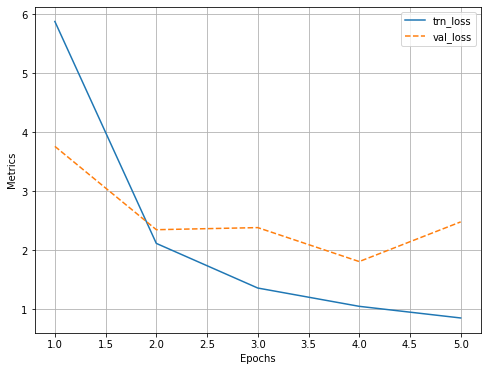

In [110]:
log.plot_epochs('trn_loss,val_loss'.split(','))

In [111]:
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.patches as mpatches
from torchvision.ops import nms
from PIL import Image
def test_predictions(filename):
    img = cv2.resize(np.array(Image.open(filename)), (224,224))
    candidates = extract_candidates(img)
    candidates = [(x,y,x+w,y+h) for x,y,w,h in candidates]
    input = preprocess_image(img/255.)[None]
    rois = [[x/224,y/224,X/224,Y/224] for x,y,X,Y in candidates]
    rixs = np.array([0]*len(rois)) # As all proposals belong to the same image, rixs will be a list of zeros (as many as the number of proposals)
    rois, rixs = [torch.Tensor(item).to(device) for item in [rois, rixs]]
    with torch.no_grad():
        frcnn.eval()
        probs, deltas = frcnn(input, rois, rixs)
        confs, clss = torch.max(probs, -1)
    candidates = np.array(candidates)
    confs, clss, probs, deltas = [tensor.detach().cpu().numpy() for tensor in [confs, clss, probs, deltas]]
    
    ixs = clss!=background_class
    confs, clss, probs, deltas, candidates = [tensor[ixs] for tensor in [confs, clss, probs, deltas, candidates]]
    bbs = candidates + deltas
    ixs = nms(torch.tensor(bbs.astype(np.float32)), torch.tensor(confs), 0.05)
    confs, clss, probs, deltas, candidates, bbs = [tensor[ixs] for tensor in [confs, clss, probs, deltas, candidates, bbs]]
    if len(ixs) == 1:
        confs, clss, probs, deltas, candidates, bbs = [tensor[None] for tensor in [confs, clss, probs, deltas, candidates, bbs]]
    
    bbs = bbs.astype(np.uint16)
    _, ax = plt.subplots(1, 2, figsize=(20,10))
    show(img, ax=ax[0])
    ax[0].grid(False)
    ax[0].set_title(filename.split('/')[-1])
    if len(confs) == 0:
        ax[1].imshow(img)
        ax[1].set_title('No objects')
        plt.show()
        return
    else:
        show(img, bbs=bbs.tolist(), texts=[target2label[c] for c in clss.tolist()], ax=ax[1])
        plt.show()

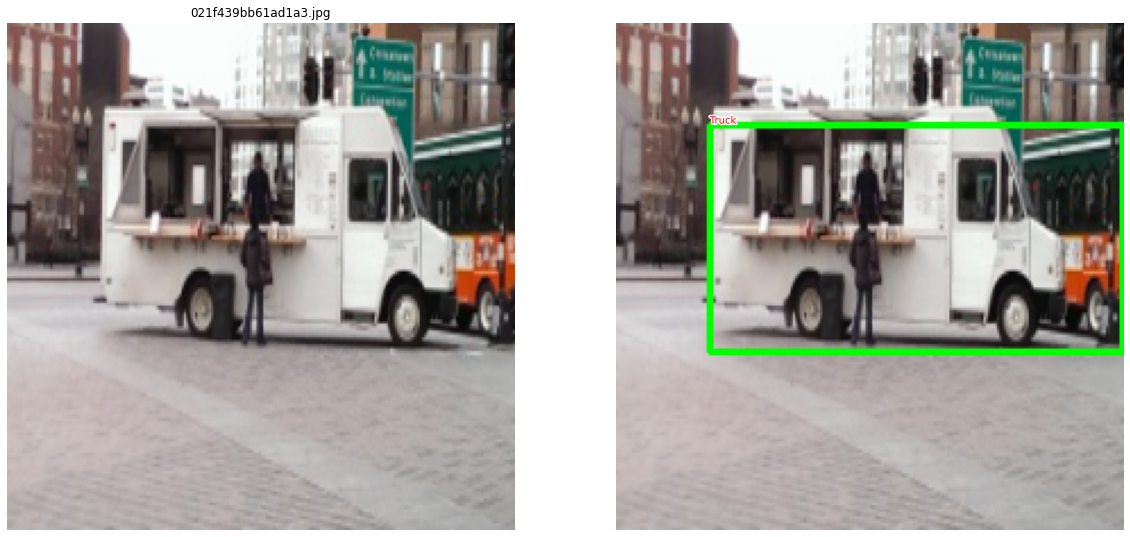

In [118]:
test_predictions(test_ds[29][-1])